# Demo on Gaussian Processes

## Gaussian Process for Non-Linear Regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## GP Regression for Noiseless Setting

### Reference: https://sandipanweb.wordpress.com/2020/12/08/gaussian-process-regression-with-python/

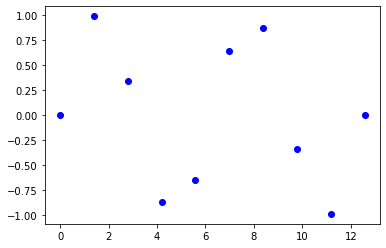

In [2]:
N_train = 10 # number of training points
N_test = 100 # number of test points

var=0.05

x_train = np.linspace(0, 4*np.pi, N_train)
y_train = np.sin(x_train)

x_test = np.linspace(0, 4*np.pi, N_test)

plt.plot(x_train,y_train,'bo')
plt.show()

### Kernel Function: Squared Exponential Function 

$k_{SE}(x,x') = \sigma^2 \exp \left( -\frac{(x-x')^2}{2l^2} \right)$

In [3]:
# squared exponential function
def Squared_Exponential(x,xp,l=1, sigma=1,):
    return (sigma**2) * np.exp(-((x-xp)**2)/(2 * (l**2)))

In [4]:
# Form the Kernel Matrix 
def Kernel_Matrix(X, Y, l):
    GaussMatrix=np.zeros(shape=(len(X),len(Y)))
    for i,x_i in enumerate(X):
        for j,y_j in enumerate(Y):
            GaussMatrix[i,j]=Squared_Exponential(x_i,y_j,l)
    return GaussMatrix

## GP: A Visualization

### GP Prior: $p(\mathbf{f})=\mathcal{N}(\mathbf{0},\mathbf{K})$ 

In [5]:
# Gaussian Prior
epsilon = 1e-6 # small variation
l_list = [0.2, 0.5, 1, 2, 10] # Different values for hyperparameter l

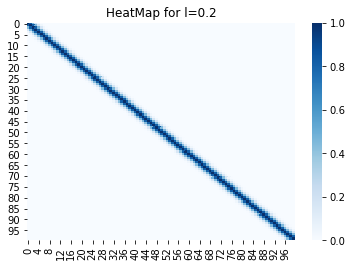

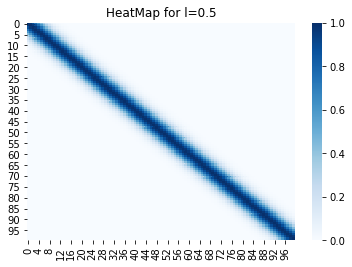

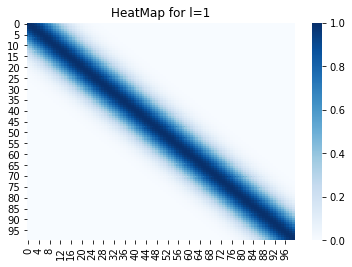

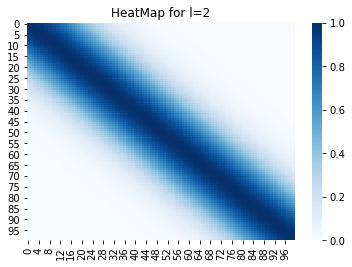

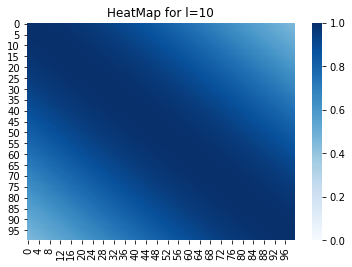

In [6]:
#Heat map of the covariance matrix
for l in l_list:
    K = Kernel_Matrix(x_test,x_test,l) 
    ax = sns.heatmap(K,vmin=0, vmax=1, cmap='Blues')
    plt.title('HeatMap for l={}'.format(l))
    plt.show()

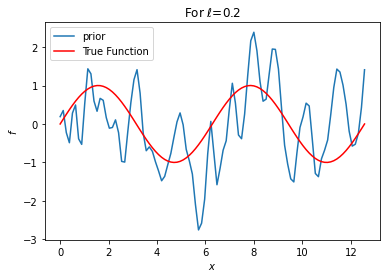

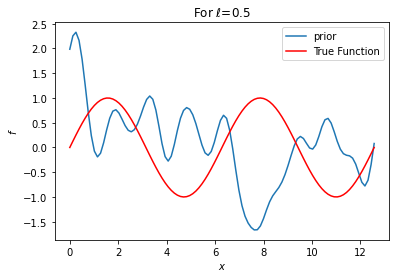

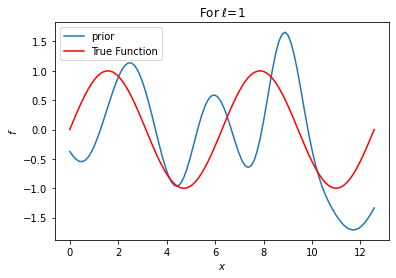

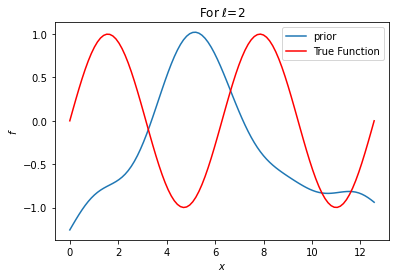

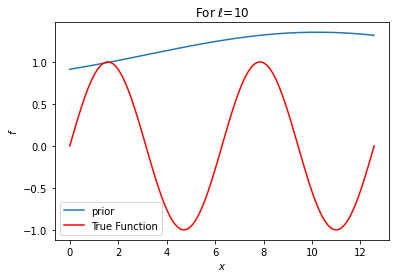

In [7]:
# Draw random funcions from the prior and plot
for l in l_list:
    prior_mean = np.zeros(len(x_test)) # GP prior mean
    prior_cov = Kernel_Matrix(x_test,x_test,l) # GP prior covariance
    f_prior = np.random.multivariate_normal(prior_mean, prior_cov)
    plt.plot(x_test,f_prior, label='prior')
    plt.plot(x_test,np.sin(x_test), color='red',label='True Function')
    plt.title('For $\ell$={}'.format(l))
    plt.xlabel('$x$')
    plt.ylabel('$f$')
    plt.legend()
    plt.show()

### PPD for noisless setting

$p(f_* \mid \mathbf{f}) = \mathcal{N}(\mathbf{k_*^{\top}} \mathbf{K}^{-1}\mathbf{f},\; k(x_*,x_*) - \mathbf{k_*^{\top}}\mathbf{K}^{-1}\mathbf{k}_*)$

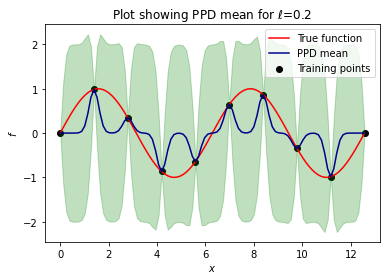

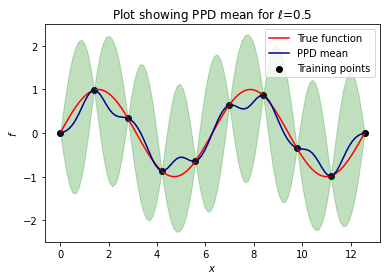

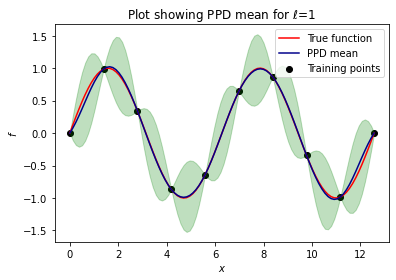

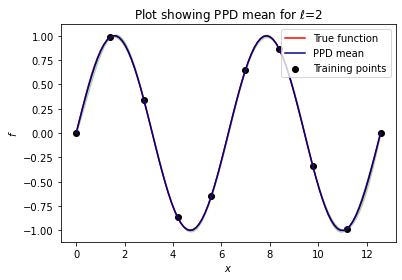

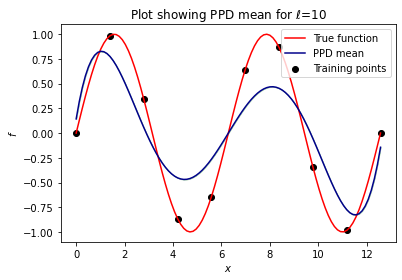

In [8]:
for l in l_list:
    K_inv = np.linalg.inv(Kernel_Matrix(x_train, x_train, l) + epsilon * np.identity(len(x_train)))

    ppd_mean = Kernel_Matrix(x_test, x_train, l) @ K_inv @ y_train
    ppd_covar = Kernel_Matrix(x_test,x_test,l) - Kernel_Matrix(x_test, x_train, l) @ K_inv \
                @ Kernel_Matrix(x_test, x_train, l).transpose()

    ppd_var = ppd_covar.diagonal()
    ppd_std = np.sqrt(ppd_var)

    plt.scatter(x_train, y_train,color="black", label="Training points")

    plt.plot(x_test, np.sin(x_test), color='red', label='True function')
    plt.plot(x_test, ppd_mean, c='darkblue', label='PPD mean')
    plt.fill_between(x_test, ppd_mean - 2*ppd_std, ppd_mean + 2*ppd_std, color='green', alpha=0.25)
    plt.title('Plot showing PPD mean for $\ell$={}'.format(l))
    plt.xlabel('$x$')
    plt.ylabel('$f$')
    plt.legend()
    plt.show()

### Draw Posteriors

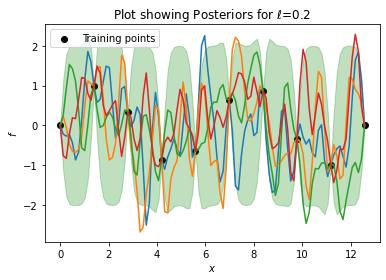

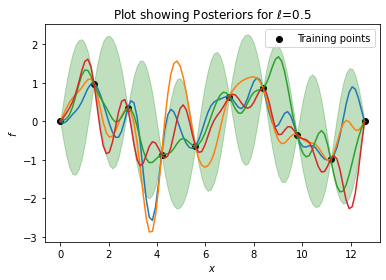

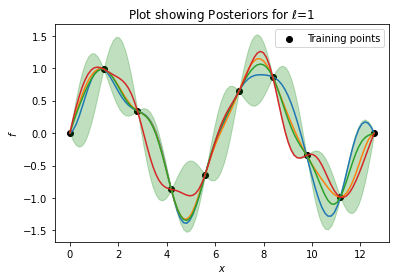

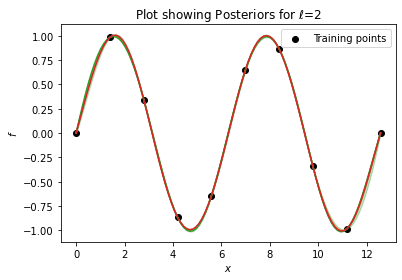

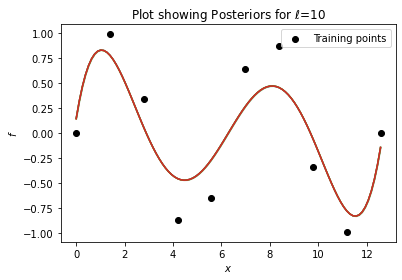

In [9]:
for l in l_list:
    K_inv = np.linalg.inv(Kernel_Matrix(x_train, x_train, l) + epsilon * np.identity(len(x_train)))

    ppd_mean = Kernel_Matrix(x_test, x_train, l) @ K_inv @ y_train
    ppd_covar = Kernel_Matrix(x_test,x_test,l) - Kernel_Matrix(x_test, x_train, l) @ K_inv \
                @ Kernel_Matrix(x_test, x_train, l).transpose()
    
    ppd_var = ppd_covar.diagonal()
    ppd_std = np.sqrt(ppd_var)
    
    f_post = np.random.multivariate_normal(ppd_mean, ppd_covar,4)

    plt.scatter(x_train, y_train,color="black", label="Training points")
    for draw in f_post:
        plt.plot(x_test, draw)

    plt.fill_between(x_test, ppd_mean - 2*ppd_std, ppd_mean + 2*ppd_std, color='green', alpha=0.25)
    plt.title('Plot showing Posteriors for $\ell$={}'.format(l))
    plt.xlabel('$x$')
    plt.ylabel('$f$')
    plt.legend()
    plt.show()

## GP Regression for noisy setting

### GP Likelihood: 
$p(\mathbf{y} \mid \mathbf{X}, \mathbf{f}) = \mathcal{N}(\mathbf{y} \mid \mathbf{f}, \beta^{-1} \mathbf{I})$

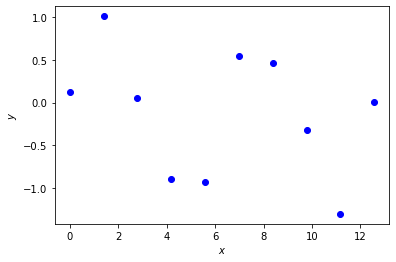

In [10]:
N_train = 10 # number of training points
N_test = 100 # number of test points

var=0.05
beta = 1/var

x_train = np.linspace(0, 4*np.pi, N_train)
y_train = np.sin(x_train) + np.random.normal(0, np.sqrt(var), len(x_train))

x_test = np.linspace(0, 4*np.pi, N_test)

plt.plot(x_train,y_train,'bo')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

### PPD for noisy setting
$p(f_* \mid \mathbf{f}) = \mathcal{N}\left(\mathbf{k_*^{\top}} \mathbf{C}_N^{-1}\mathbf{f},\; k(x_*,x_*) - \mathbf{k_*^{\top}}\mathbf{C}_N^{-1}\mathbf{k}_* + \beta^{-1}\right)$

where,
$\mathbf{C}_N = \mathbf{K}+\beta^{-1} \mathbf{I}_N$

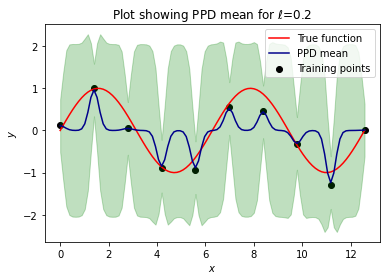

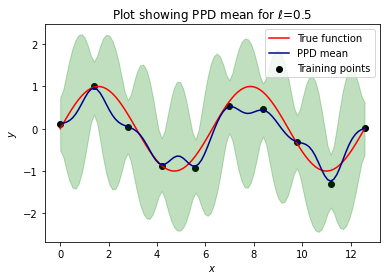

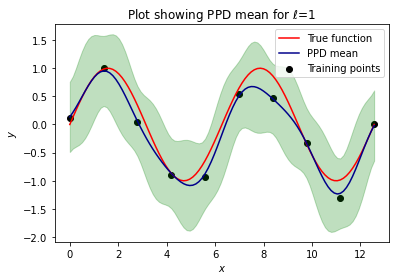

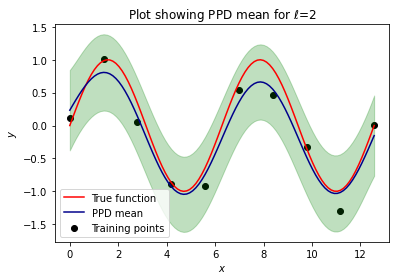

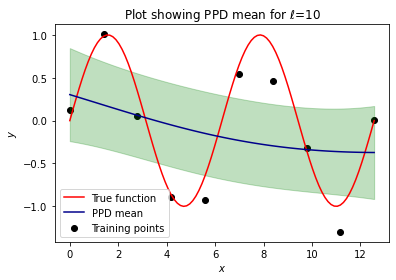

In [11]:
for l in l_list:
    C_N = np.linalg.inv(Kernel_Matrix(x_train, x_train, l) + var * np.identity(len(x_train)))

    ppd_mean = Kernel_Matrix(x_test, x_train, l) @ C_N @ y_train
    ppd_covar = Kernel_Matrix(x_test,x_test,l) - Kernel_Matrix(x_test, x_train, l) @ C_N @\
                Kernel_Matrix(x_test, x_train, l).transpose() + var

    ppd_var = ppd_covar.diagonal()
    ppd_std = np.sqrt(ppd_var)

    plt.scatter(x_train, y_train,color="black", label="Training points")

    plt.plot(x_test, np.sin(x_test), color='red', label='True function')
    plt.plot(x_test, ppd_mean, c='darkblue', label='PPD mean')
    plt.fill_between(x_test, ppd_mean - 2*ppd_std, ppd_mean + 2*ppd_std, color='green', alpha=0.25)
    plt.title('Plot showing PPD mean for $\ell$={}'.format(l))
    plt.legend()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.show()

### Draw Posteriors

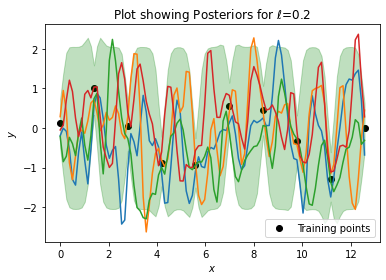

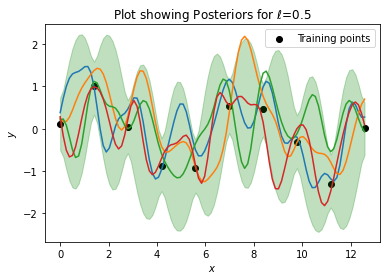

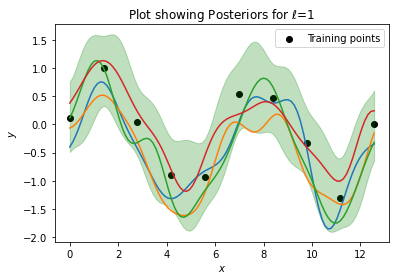

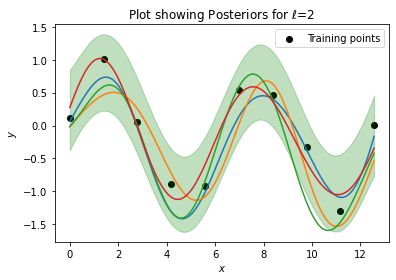

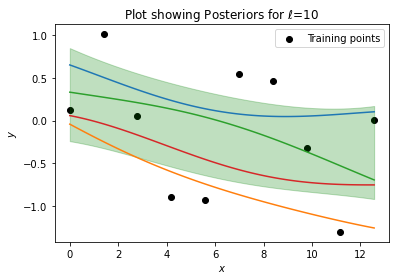

In [12]:
for l in l_list:
    C_N = np.linalg.inv(Kernel_Matrix(x_train, x_train, l) + var * np.identity(len(x_train)))

    ppd_mean = Kernel_Matrix(x_test, x_train, l) @ C_N @ y_train
    ppd_covar = Kernel_Matrix(x_test,x_test,l) - Kernel_Matrix(x_test, x_train, l) @ C_N @\
                Kernel_Matrix(x_test, x_train, l).transpose() + var

    ppd_var = ppd_covar.diagonal()
    ppd_std = np.sqrt(ppd_var)
    
    f_post = np.random.multivariate_normal(ppd_mean, ppd_covar,4)

    plt.scatter(x_train, y_train,color="black", label="Training points")
    for draw in f_post:
        plt.plot(x_test, draw)

    plt.fill_between(x_test, ppd_mean - 2*ppd_std, ppd_mean + 2*ppd_std, color='green', alpha=0.25)
    plt.title('Plot showing Posteriors for $\ell$={}'.format(l))
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    plt.show()